# Analysis

This notebook is the primary analysis notebook for tau_map6 simulations. This is loosely based off `first_analysis.ipynb` with additional functionality from `data_process_funcs.py`.

## Notebook Configuration

In [2]:
# import packages
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colormaps

from rich import print
from tqdm import tqdm

In [3]:
# import functions
from data_process_funcs import *

In [4]:
# configure plotting
# define the figure save directory
figure_dir = Path("figures")
os.makedirs(figure_dir, exist_ok=True)

# set plot style
cstyle_file_url = r"https://gist.githubusercontent.com/CalvinSprouse/30bba681da1dd0023e948ca207fad0fc/raw/80a1ae94031873a57c9624103e83f5caf175ac86/cstyle.mplstyle"
plt.style.use(["default", cstyle_file_url])

## Define Plotting Functions

In [5]:
# define a function to make a grouped bar plot
def grouped_bar_plot(fig, ax,
                     group_data: dict,
                     group_labels: list,
                     colors: list = None,
                     bar_width: float = 0.2,
                     multiplier: float = 0,
                     **kwargs):
    """Plots a grouped bar plot

    Arguments:
        fig -- _description_
        ax -- _description_
        group_data -- _description_

    Keyword Arguments:
        colors -- _description_ (default: {None})
        bar_width -- _description_ (default: {0.2})
        multiplier -- _description_ (default: {0})

    Raises:
        ValueError: _description_

    Returns:
        _description_
    """

    # extract groups from keys of group_data
    group_count = len(group_labels)

    # the default value of colors should be a built in color list
    if colors is None:
        colors = colormaps["tab10"].colors
    else:
        # check if the length of colors is greater than the number of groups
        if len(colors) < group_count:
            raise ValueError("The number of colors provided is less than the number of groups")

    # define the label locations
    x_locations = np.arange(group_count)

    # plot the bars
    for index, attr_meas in enumerate(group_data.items()):
        # unpack attr_meas
        attribute = attr_meas[0]
        measurement = attr_meas[1]

        # calculate the offset location of each bar
        offset = bar_width * multiplier

        # draw the bar and insert kwargs
        ax.bar(
            x_locations + offset,
            measurement,
            bar_width,
            label=attribute,
            color=colors[index],
            **kwargs
        )

        # iterate the multiplier to space the next bar
        multiplier += 1

    # set the x ticks
    ax.set_xticks(x_locations + bar_width, group_labels)

    return fig, ax

## Import Data

In [6]:
# define the data directory
data_dir = Path("data", "raw_sim_data")

# get the .mat files from data_dir
mat_files = list(data_dir.glob("*.mat"))

In [7]:
# define a list of variables to extract from mat_files
value_list = ["T0", "M0", "taufractip", "taufraclength", "tauplusendasym", "mapfractip", "mapfraclength", "mapplusendasym", "L", "save_str", "MTlength", "MTgrid", "x", "t"]

# convert mat files to sim_dict and sim_df
sim_dict = extract_sim_dict(mat_files, value_list)
sim_df = create_sim_df(sim_dict)

## Process Data

In [8]:
# calculate new column values
# calculate T0/M0
sim_df["T0/M0"] = sim_df["T0"] / sim_df["M0"]

In [9]:
# create an average df indexed by T0/M0
sim_avg_df = sim_df.groupby("T0/M0").mean()

## Averages DF Plotting

### Binding Rate Ratio vs. MT Length

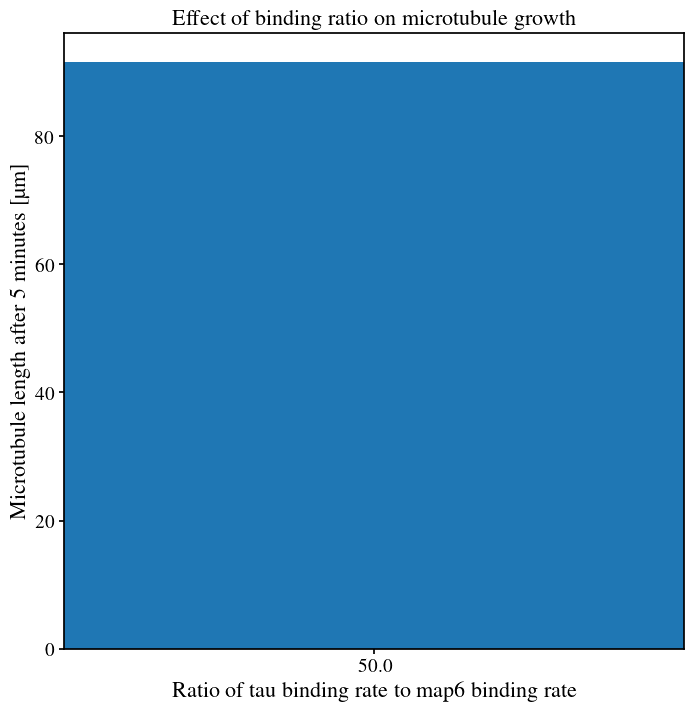

In [10]:
# define the grouped data and group labels
group_data = {"L": sim_avg_df["L"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the grouped bar plot
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Microtubule length after 5 minutes [$\qty{}{\micro\meter}$]")
ax.set_title(r"Effect of binding ratio on microtubule growth")

# save the figure
fig.savefig(figure_dir / r"growth_effect")

### Binding Asymmetry

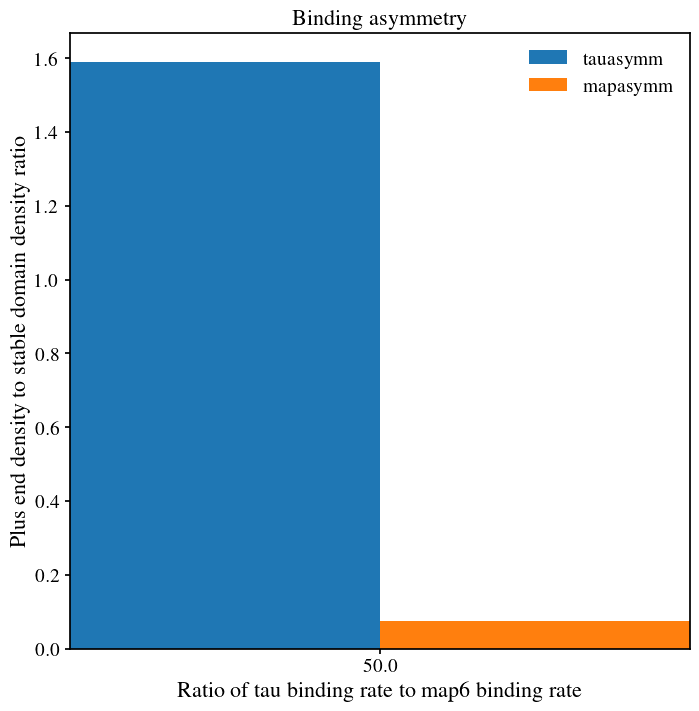

In [11]:
# make a grouped bar plot of binding asymmetry
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. tau plus end density to stable domain density ratio (tauasymm)
# 2. map6 plus end density to stable domain density ratio (mapasymm)

# define the group data and group labels
group_data = {"tauasymm": sim_avg_df["tauplusendasym"], "mapasymm": sim_avg_df["mapplusendasym"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1/2)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Plus end density to stable domain density ratio")
ax.set_title(r"Binding asymmetry")

# set the legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"asymm_effect")

### Distribution Dependence on Tau On-Rate

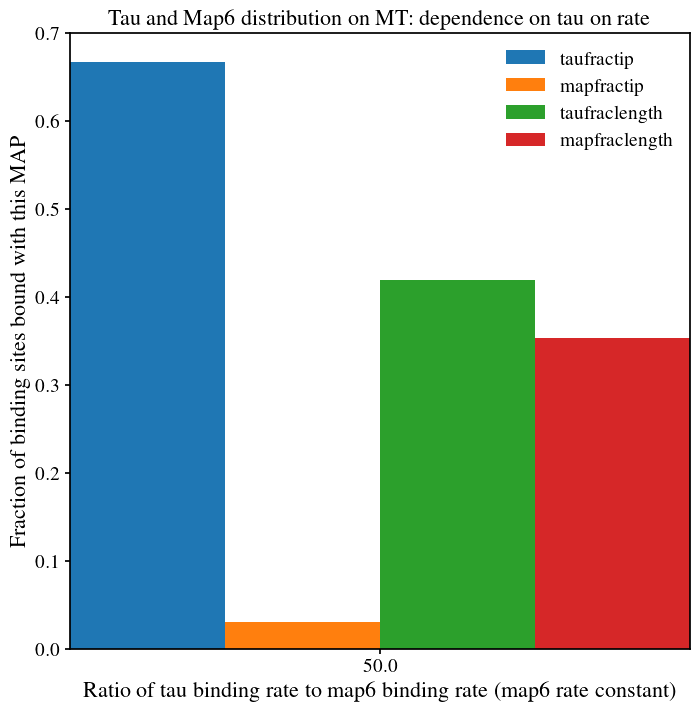

In [12]:
# make a grouped bar plot
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. plus-end tau fraction (taufractip)
# 2. plus-end map6 fraction (mapfractip)
# 3. stable domain tau fraction (taufraclength)
# 4. stable domain map6 fraction (mapfraclength)

# define the group data and group labels (T0/M0)
group_data = {
    "taufractip": sim_avg_df["taufractip"],
    "mapfractip": sim_avg_df["mapfractip"],
    "taufraclength": sim_avg_df["taufraclength"],
    "mapfraclength": sim_avg_df["mapfraclength"],
}
group_labels = sim_avg_df.index

# define the colors
colors = ["orange", "blue", "grey", "green"]

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=-1/2)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate (map6 rate constant)")
ax.set_ylabel(r"Fraction of binding sites bound with this MAP")
ax.set_title(r"Tau and Map6 distribution on MT: dependence on tau on rate")

# add a legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"binding_distribution_grouped")

## Individual Plotting

### Plot MT Length Over Time

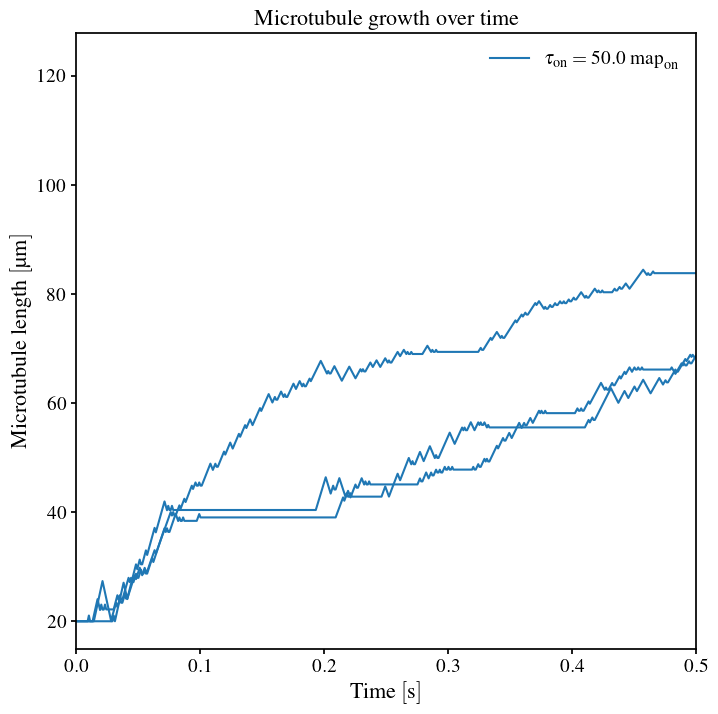

In [13]:
# plot the length of the microtube over time
# define the figure
fig, ax = plt.subplots()

# get a list of colors to iterate over
colors = list(colormaps["tab10"].colors)

# define a dictionary to color similar tau_ratios
tau_ratio_dict = {}

# iterate over each simulation in sim_dict and get the time and length array
for sim_name in sim_dict.keys():
    # get the arrays
    mt_length_array = sim_dict[sim_name]["MTlength"]
    length_list = mt_length_array[:, 1]
    time_list = mt_length_array[:, 0]

    # get the tau binding rate T0 ratio
    tau_ratio = sim_df["T0/M0"][sim_name]

    # define the label
    label = r"$\tau_{\text{on}}=" + f"{tau_ratio}" + r"\ \text{map}_\text{on}$"

    # get a unique color for each tau ratio
    # if the color has been used, make the label None
    if tau_ratio not in tau_ratio_dict.keys():
        tau_ratio_dict[tau_ratio] = colors.pop(0)
    else:
        label = None

    # plot the length over time for this mt
    ax.plot(
        time_list,
        length_list,
        label=label,
        color=tau_ratio_dict[tau_ratio]
    )

# set the axis limits
# the x limit should be the final time plus the second time
# this has the effect of showing an "even" value
ax.set_xlim(0, time_list[-1] + time_list[1])

# set the labels
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Microtubule length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title(r"Microtubule growth over time")

# add a legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"mt_growth_over_time")

### Plot tau map6 Distribution

#### Select simulation and time step

In [14]:
# select a sim name
distribution_sim_name = "T0_5_2"

# select a time step between 0 and N-1
distribution_time_step = 999

#### Extract the Distribution Information

In [15]:
# extract some values
time_value = sim_dict[distribution_sim_name]["t"][distribution_time_step]
length_value = sim_dict[distribution_sim_name]["MTlength"][distribution_time_step][1]

# get that row of MTgrid
mt_state = sim_dict[distribution_sim_name]["MTgrid"][distribution_time_step]

# get the first index of -1 from mt_state, then remove all entries beyond
# consider that there may be no entries of -1
try:
    minus_one_index = np.where(mt_state == -1)[0][0]
    mt_state = mt_state[:minus_one_index]
except IndexError:
    pass

# calculate grid information
binding_sites = len(mt_state)
grid_spacing = length_value / (binding_sites - 1)
grid_positions = np.arange(0, length_value + grid_spacing, grid_spacing)

# join grid_positions and mt_state as columns in a np array
mt_state_array = np.column_stack((grid_positions, mt_state))

#### Plot using a point representation

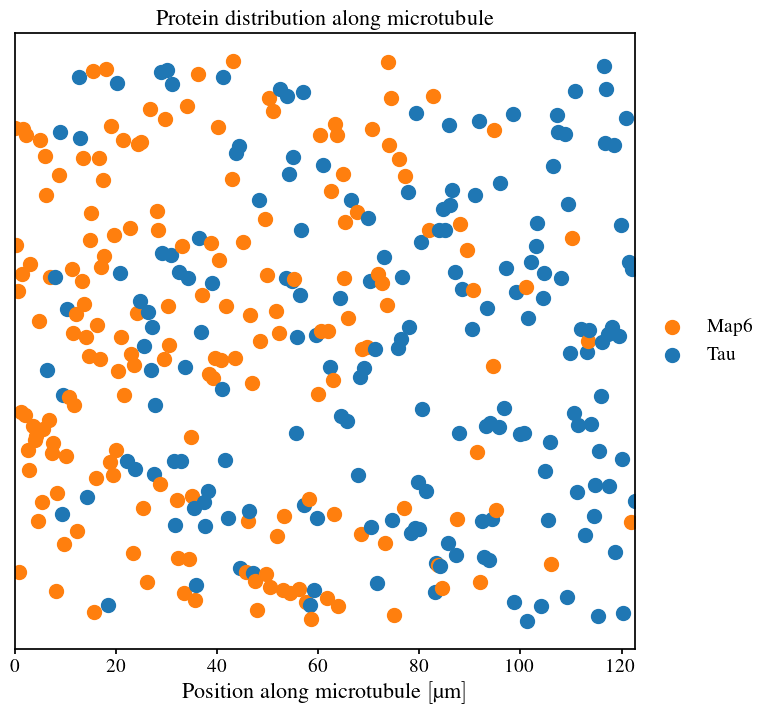

In [16]:
# plot the map6 distribution along an MT
# define the figure
fig, ax = plt.subplots()

# get a list of colors
colors = colormaps["tab10"].colors

# booleans for tracking label status
tau_label = False
map6_label = False

# use the mt_state_array to plot the locations of proteins
# do not plot the zero values
for (pos, protein) in mt_state_array:
    # protein = 1 means tau
    # protein = 2 means map6
    # check that the protein value is not 0
    if protein == 0: continue

    # use the protein value to determine the color
    if protein == 1: color = colors[0]
    elif protein == 2: color = colors[1]

    # determine if the label should be added
    label = None
    if protein == 1 and not tau_label:
        label = r"Tau"
        tau_label = True
    elif protein == 2 and not map6_label:
        label = r"Map6"
        map6_label = True

    # define a random vertial position to differentiate points
    vert_pos = np.random.uniform(0, 1)

    # plot the protein as a dot
    ax.scatter(
        pos,
        vert_pos,
        color=color,
        s=100,
        label=label
    )

# remove the vertical axis labels
ax.set_yticks([])

# set the labels
ax.set_xlabel(r"Position along microtubule $\left[\qty{}{\micro\meter}\right]$")
ax.set_title(r"Protein distribution along microtubule")

# add a legend outside the figure
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# save the figure
fig.savefig(figure_dir / r"protein_distribution")

#### Extract clustering information

In [17]:
# a domain is an uninterupted segment of the same type of protein
# extract domain information into a 6 column array
# column 1 is the start position
# column 2 is the width
# column 3 is the end position
# column 4 is the center position
# column 5 is the number of proteins
# column 6 is the protein type

# define the domain dictionary
domain_dict = {
    "start_pos": [],
    "width": [],
    "end_pos": [],
    "center_pos": [],
    "num_proteins": [],
    "protein_type": []
}

# track the start position of the current domain and protein type
start_pos = mt_state_array[0][0]
start_index = 0
protein_type = mt_state_array[0][1]

# iterate over the mt_state_array
for i, (pos, protein) in enumerate(mt_state_array):
    # check if the protein type has changed or its the last entry
    if protein != protein_type or i == len(mt_state_array) - 1:
        # calculate the domain width and center
        domain_width = pos - start_pos
        domain_center = start_pos + domain_width / 2

        # append the domain to the domain_dict
        domain_dict["start_pos"].append(start_pos)
        domain_dict["width"].append(domain_width)
        domain_dict["end_pos"].append(pos)
        domain_dict["center_pos"].append(domain_center)
        domain_dict["num_proteins"].append(int(i - start_index))
        domain_dict["protein_type"].append(int(protein_type))

        # update the start position and protein type
        start_pos = pos
        start_index = i
        protein_type = protein

# convert the domain_dict to a dataframe
domain_df = pd.DataFrame(domain_dict)


#### Plot using groups based on length of clusters

In [21]:
# plot the domain information
# define the figure
fig, ax = plt.subplots(figsize=(16, 9))

# toggles
# invert the map6 axis for readability
invert_map6 = True
# plot a dot for each protein on the horizontal line
protein_points = True

# get a list of colors
colors = colormaps["tab10"].colors

# use the domain_df to plot the domain information
for (i, start_pos, width, end_pos, center_pos, num_proteins, protein_type) in domain_df.itertuples():
    # skip protein_type 0
    if protein_type == 0: continue

    # use the protein type to determine the color
    if protein_type == 1: color = colors[0]
    elif protein_type == 2: color = colors[1]

    # get height_scale and check for map6 inversion
    height_scale = 1
    if protein_type == 2 and invert_map6:
        height_scale = -1

    # use a point with a horizontal error bar
    ax.errorbar(
        center_pos,
        num_proteins*height_scale,
        xerr=width / 2,
        fmt="o",
        # color=color,
        color="black",
        markersize=0
    )

    # shade the region below the bar with no outline
    ax.fill_between(
        [start_pos, end_pos],
        0,
        num_proteins*height_scale,
        color=color,
        alpha=1,
        linewidth=0
    )

# plot each protein on the horizontal if protein points
if protein_points:
    for (pos, protein) in mt_state_array:
        # protein = 1 means tau
        # protein = 2 means map6
        # check that the protein value is not 0
        if protein == 0: continue

        # use the protein value to determine the color
        if protein == 1: color = colors[0]
        elif protein == 2: color = colors[1]

        # determine if the label should be added
        label = None
        if protein == 1 and not tau_label:
            label = r"Tau"
            tau_label = True
        elif protein == 2 and not map6_label:
            label = r"Map6"
            map6_label = True

        # plot the protein as a dot
        ax.scatter(
            pos,
            0,
            color=color,
            s=5,
            label=label
        )
else:
    # draw a black line at y=0
    ax.axhline(0, color="black")

# make y-axis limits symmetric
# get the largest value on the y-axis
y_lim_upper = ax.get_ylim()
y_lim_upper = max(abs(y_lim_upper[0]), abs(y_lim_upper[1]))
# round to the nearest multiple of five
y_lim_upper = 5 * round(y_lim_upper / 5)
# check if the lower limit should be 0
y_lim_lower = -y_lim_upper if invert_map6 else 0
# set the y-axis limits
ax.set_ylim(y_lim_lower, y_lim_upper)

# relabel the y-axis in absolute value using a formatter
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{abs(x):.0f}"))

# set the labels
ax.set_xlabel(r"Position along microtubule $\left[\qty{}{\micro\meter}\right]$")
ax.set_ylabel(r"Number of proteins in uninterupted sequence")
ax.set_title(r"Protein cluster distribution along microtubule")

# add a legend with a label for map6 and tau using artists
# the label should be a colored rectangle
tau_label = plt.Rectangle((0, 0), 1, 1, fc=colors[0])
map6_label = plt.Rectangle((0, 0), 1, 1, fc=colors[1])
# tau_label = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[0], markersize=10)
# map6_label = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[1], markersize=10)
# add legend to the upper-left
# ax.legend([tau_label, map6_label], ["Tau", "Map6"])
ax.legend([tau_label, map6_label], ["Tau", "Map6"], loc="upper left")

# save the figure
fig.savefig(figure_dir / r"protein_cluster_distribution")